<h1 align="center"> Image Captioning (10 баллов) </h1>

В этом ноутбуке вы обучите сеть составлять подписи к изображениям.
![img](https://i.imgur.com/obITaMl.png)


#### План работы:

1. Использовать предобученную модель Inception v3 для преобразования изображений в векторы.

2. Добавить поверх неё LSTM.

3. Обучить модель на датасете [MSCOCO](http://cocodataset.org/#download).

### 1. Данные (0.5 балла)

In [ ]:
# Скачайте датасет по ссылке https://drive.google.com/file/d/1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO/view?usp=sharing

In [1]:
!gdown 1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO

Downloading...
From (original): https://drive.google.com/uc?id=1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO
From (redirected): https://drive.google.com/uc?id=1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO&confirm=t&uuid=dd7b75ef-141c-4b1e-9344-6f8329cfc3ee
To: /content/handout.tar.gz
100% 884M/884M [00:13<00:00, 63.7MB/s]


In [4]:
!tar -xvzf handout.tar.gz

data/
data/captions_tokenized.json
data/image_codes.npy


In [5]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 152 ms, sys: 362 ms, total: 515 ms
Wall time: 583 ms



Чтобы сэкономить ваше время, мы уже преобразовали все изображения из MSCOCO17 в векторы с помощью предобученной сети Inception_v3 из библиотеки [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

Весь процесс занимает от одного дня на CPU до примерно 10 минут на трёх GPU Tesla M40. [Если хотите попробовать сделать это самостоятельно — пожалуйста.](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).


In [6]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как видно, все подписи уже токенизированы и приведены к нижнему регистру. Теперь нам нужно разделить их и добавить специальные токены, обозначающие начало и конец подписи.

In [7]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


Мы не хотим, чтобы сеть на каждом шаге предсказывала вероятности для миллиона слов, поэтому нужно немного сократить словарь.

Для этого посчитайте, **сколько раз встречается каждое слово** — так мы сможем решить, какие слова оставить в словаре.

In [8]:
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions
for img_captions in captions:
    for caption_tokens in img_captions:
        word_counts.update(caption_tokens)

In [9]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [10]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [11]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### 2. Построение нейронной сети (1.5 балла)

Как уже упоминалось, мы создадим RNN-модель для генерации текста, которая будет зависеть от векторов, полученных из CNN-части сети.

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

Во время обучения мы будем использовать уже готовые вектора-признаков, а сеть Inception добавим на этапе инференса.


In [12]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [13]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()

        # a layer that converts conv features to
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)

        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM.
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)

        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)

    def forward(self, image_vectors, captions_ix):
        """
        Apply the network in training mode.
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)

        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)

        # apply recurrent layer to captions_emb.
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (initial_hid[None], initial_cell[None]))

        # compute logits from lstm_out
        logits = self.logits(lstm_out)

        return logits

In [14]:
network = CaptionNet(n_tokens)

In [15]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [22]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """

    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()

    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)

    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    loss = F.cross_entropy(
        logits_for_next.reshape(-1, logits_for_next.shape[-1]),
        captions_ix_next.reshape(-1),
        ignore_index=pad_ix,
        reduction='mean'
    )

    loss = loss.view(1)

    return loss

In [23]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'


Добавьте ~~adam~~ ваш любимы оптимизатор для обучения.

In [24]:
optimizer = torch.optim.AdamW(
    network.parameters(),
    lr=1e-3,
    weight_decay=1e-5
)

### 3. Обучение (5 баллов)

* Сначала реализуйте генератор батчей.
* Затем обучите сеть как обычно.

In [27]:
from sklearn.model_selection import train_test_split

captions = np.array(captions, dtype=object)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(
    img_codes,
    captions,
    test_size=0.1,
    random_state=42
)

In [28]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):

    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)

    #get images
    batch_images = img_codes[random_image_ix]

    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]

    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))

    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)

    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)


In [29]:
generate_batch(img_codes,captions,3)

(tensor([[0.7395, 0.6565, 0.1310,  ..., 0.0000, 0.6130, 0.1608],
         [0.0302, 0.3103, 0.3030,  ..., 0.0012, 0.0770, 0.9587],
         [0.3400, 0.2323, 0.2578,  ..., 0.1478, 0.2218, 0.0000]]),
 tensor([[   1,  514,  587,  894, 4835,  123, 2794,  123,   15,   24, 1213,  123,
           956,  184,   12,    2],
         [   1,   24,  158,   63,  136,   88, 1575,   35,  156,   12,    2,    3,
             3,    3,    3,    3],
         [   1,   24,  115,   57,   51,  185,   24,  272, 1005,   72, 1749,  986,
             2,    3,    3,    3]]))

Обучайте модель на мини-батчах, как обычно. Периодически проверяйте качество на валидационном наборе.

#### **Советы**

* Если тренировочный лосс почти равен нулю или модель генерирует бессмысленный текст — проверьте, что вы предсказываете следующее слово, а не текущее или слово через два шага.

* Если модель создаёт плавные, но нерелевантные описания:

  * возможно, рекуррентная сеть не получает векторы изображения;

  * также это может быть следствием взрыва градиентов — попробуйте клиппинг или перезапуск обучения;

  * наконец, возможно, модель просто нужно обучить дольше.

* Кросс-энтропия — слабый показатель переобучения:

  * модель может переобучиться по валидационной кросс-энтропии, но при этом продолжать улучшать качество генерации;

  * используйте ручную оценку или автоматические метрики, такие как CIDEr или BLEU.

* Рекомендуется периодически проверять сеть с помощью блока “apply trained model” — можно остановить обучение, протестировать несколько примеров и продолжить.

* Типичные значения функции потерь: около 3–5, если усреднять по времени,
или масштабировать по длине при суммировании. Разумные подписи начинают появляться при лоссе 2.8–3.0.

In [30]:
batch_size = 50  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [31]:
from tqdm import tqdm

for epoch in range(n_epochs):

    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):

        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))


        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()

        train_loss += loss_t.item()

    train_loss /= n_batches_per_epoch

    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches

    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|██████████| 50/50 [00:16<00:00,  3.02it/s]



Epoch: 0, train loss: 6.0069614505767825, val loss: 4.951552295684815


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]



Epoch: 1, train loss: 4.739069881439209, val loss: 4.59138298034668


100%|██████████| 50/50 [00:18<00:00,  2.68it/s]



Epoch: 2, train loss: 4.445638389587402, val loss: 4.3358378410339355


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]



Epoch: 3, train loss: 4.262897148132324, val loss: 4.342463588714599


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]



Epoch: 4, train loss: 4.172579669952393, val loss: 4.086016035079956


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]



Epoch: 5, train loss: 4.043951959609985, val loss: 3.928754711151123


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]



Epoch: 6, train loss: 3.932462382316589, val loss: 3.9831451892852785


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]



Epoch: 7, train loss: 3.837016534805298, val loss: 3.862472677230835


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]



Epoch: 8, train loss: 3.785238962173462, val loss: 3.858646297454834


100%|██████████| 50/50 [00:17<00:00,  2.79it/s]



Epoch: 9, train loss: 3.7196413707733154, val loss: 3.5770713329315185


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]



Epoch: 10, train loss: 3.6264519834518434, val loss: 3.4430846691131594


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]



Epoch: 11, train loss: 3.538270583152771, val loss: 3.5982781410217286


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]



Epoch: 12, train loss: 3.548499946594238, val loss: 3.549768495559692


100%|██████████| 50/50 [00:16<00:00,  3.11it/s]



Epoch: 13, train loss: 3.4696487855911253, val loss: 3.3906084060668946


100%|██████████| 50/50 [00:16<00:00,  3.03it/s]



Epoch: 14, train loss: 3.4140802097320555, val loss: 3.5048646926879883


100%|██████████| 50/50 [00:17<00:00,  2.91it/s]



Epoch: 15, train loss: 3.3586742973327635, val loss: 3.271059846878052


100%|██████████| 50/50 [00:17<00:00,  2.86it/s]



Epoch: 16, train loss: 3.347458062171936, val loss: 3.249483919143677


100%|██████████| 50/50 [00:16<00:00,  3.00it/s]



Epoch: 17, train loss: 3.3281195831298827, val loss: 3.3868066310882567


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]



Epoch: 18, train loss: 3.2495848417282103, val loss: 3.3699954986572265


100%|██████████| 50/50 [00:19<00:00,  2.59it/s]



Epoch: 19, train loss: 3.26316734790802, val loss: 3.280988883972168


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]



Epoch: 20, train loss: 3.2519926404953003, val loss: 3.2350483894348145


100%|██████████| 50/50 [00:16<00:00,  3.02it/s]



Epoch: 21, train loss: 3.2074916315078736, val loss: 3.1228338718414306


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]



Epoch: 22, train loss: 3.163119387626648, val loss: 3.243950843811035


100%|██████████| 50/50 [00:15<00:00,  3.32it/s]



Epoch: 23, train loss: 3.168166871070862, val loss: 3.291754198074341


100%|██████████| 50/50 [00:16<00:00,  3.09it/s]



Epoch: 24, train loss: 3.160183300971985, val loss: 3.1158235549926756


100%|██████████| 50/50 [00:14<00:00,  3.43it/s]



Epoch: 25, train loss: 3.073862066268921, val loss: 3.0934142589569094


100%|██████████| 50/50 [00:14<00:00,  3.43it/s]



Epoch: 26, train loss: 3.0910441398620607, val loss: 3.198188304901123


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]



Epoch: 27, train loss: 3.0895465564727784, val loss: 3.172676658630371


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]



Epoch: 28, train loss: 3.0738046407699584, val loss: 3.040683364868164


100%|██████████| 50/50 [00:16<00:00,  3.11it/s]



Epoch: 29, train loss: 3.0529863929748533, val loss: 2.9922827243804933


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]



Epoch: 30, train loss: 3.048817763328552, val loss: 3.01433744430542


100%|██████████| 50/50 [00:15<00:00,  3.17it/s]



Epoch: 31, train loss: 2.9981848859786986, val loss: 3.056432104110718


100%|██████████| 50/50 [00:17<00:00,  2.94it/s]



Epoch: 32, train loss: 3.0392883682250975, val loss: 2.917625904083252


100%|██████████| 50/50 [00:16<00:00,  3.02it/s]



Epoch: 33, train loss: 2.995967707633972, val loss: 3.0955512523651123


100%|██████████| 50/50 [00:16<00:00,  3.05it/s]



Epoch: 34, train loss: 3.0179438400268555, val loss: 2.962227725982666


100%|██████████| 50/50 [00:18<00:00,  2.71it/s]



Epoch: 35, train loss: 2.99384491443634, val loss: 3.036026668548584


100%|██████████| 50/50 [00:17<00:00,  2.79it/s]



Epoch: 36, train loss: 2.9167470741271972, val loss: 2.943830394744873


100%|██████████| 50/50 [00:20<00:00,  2.45it/s]



Epoch: 37, train loss: 2.945536484718323, val loss: 2.9478166103363037


100%|██████████| 50/50 [00:18<00:00,  2.78it/s]



Epoch: 38, train loss: 2.943090558052063, val loss: 3.044330024719238


100%|██████████| 50/50 [00:18<00:00,  2.71it/s]



Epoch: 39, train loss: 2.938160624504089, val loss: 3.0160136222839355


100%|██████████| 50/50 [00:18<00:00,  2.68it/s]



Epoch: 40, train loss: 2.9430847930908204, val loss: 2.871049499511719


100%|██████████| 50/50 [00:17<00:00,  2.82it/s]



Epoch: 41, train loss: 2.895211114883423, val loss: 2.9900439739227296


100%|██████████| 50/50 [00:17<00:00,  2.80it/s]



Epoch: 42, train loss: 2.923363962173462, val loss: 3.0458725452423097


100%|██████████| 50/50 [00:16<00:00,  3.01it/s]



Epoch: 43, train loss: 2.879270620346069, val loss: 2.880253314971924


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]



Epoch: 44, train loss: 2.8780759954452515, val loss: 2.9768072605133056


100%|██████████| 50/50 [00:18<00:00,  2.74it/s]



Epoch: 45, train loss: 2.8889895391464235, val loss: 2.865453815460205


100%|██████████| 50/50 [00:17<00:00,  2.94it/s]



Epoch: 46, train loss: 2.890329041481018, val loss: 2.9411073684692384


100%|██████████| 50/50 [00:19<00:00,  2.63it/s]



Epoch: 47, train loss: 2.880445609092712, val loss: 2.777370643615723


100%|██████████| 50/50 [00:18<00:00,  2.69it/s]



Epoch: 48, train loss: 2.8456618976593018, val loss: 2.743287706375122


100%|██████████| 50/50 [00:17<00:00,  2.91it/s]



Epoch: 49, train loss: 2.8330214643478393, val loss: 3.0147566318511965


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]



Epoch: 50, train loss: 2.7924712085723877, val loss: 2.7866036891937256


100%|██████████| 50/50 [00:18<00:00,  2.68it/s]



Epoch: 51, train loss: 2.814483609199524, val loss: 2.7999722003936767


100%|██████████| 50/50 [00:17<00:00,  2.87it/s]



Epoch: 52, train loss: 2.8110879707336425, val loss: 2.8747350215911864


100%|██████████| 50/50 [00:17<00:00,  2.81it/s]



Epoch: 53, train loss: 2.8293271112442016, val loss: 2.8213505268096926


100%|██████████| 50/50 [00:17<00:00,  2.79it/s]



Epoch: 54, train loss: 2.811940155029297, val loss: 2.9992372512817385


100%|██████████| 50/50 [00:17<00:00,  2.78it/s]



Epoch: 55, train loss: 2.7997083711624144, val loss: 2.81375789642334


100%|██████████| 50/50 [00:18<00:00,  2.76it/s]



Epoch: 56, train loss: 2.7736295652389527, val loss: 2.854263687133789


100%|██████████| 50/50 [00:17<00:00,  2.89it/s]



Epoch: 57, train loss: 2.8109306383132933, val loss: 2.9016871452331543


100%|██████████| 50/50 [00:18<00:00,  2.64it/s]



Epoch: 58, train loss: 2.8039160442352293, val loss: 2.888334941864014


100%|██████████| 50/50 [00:19<00:00,  2.53it/s]



Epoch: 59, train loss: 2.803026547431946, val loss: 2.8018990039825438


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]



Epoch: 60, train loss: 2.768502354621887, val loss: 2.7463500022888185


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]



Epoch: 61, train loss: 2.7435918378829958, val loss: 2.7829683303833006


100%|██████████| 50/50 [00:18<00:00,  2.76it/s]



Epoch: 62, train loss: 2.775492057800293, val loss: 2.771956777572632


100%|██████████| 50/50 [00:20<00:00,  2.48it/s]



Epoch: 63, train loss: 2.7681807851791382, val loss: 2.8632970809936524


100%|██████████| 50/50 [00:18<00:00,  2.78it/s]



Epoch: 64, train loss: 2.7271215534210205, val loss: 2.755135917663574


100%|██████████| 50/50 [00:19<00:00,  2.53it/s]



Epoch: 65, train loss: 2.782908444404602, val loss: 2.8243269443511965


100%|██████████| 50/50 [00:18<00:00,  2.64it/s]



Epoch: 66, train loss: 2.7388453674316406, val loss: 2.70477352142334


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]



Epoch: 67, train loss: 2.760482521057129, val loss: 2.7496711730957033


100%|██████████| 50/50 [00:17<00:00,  2.84it/s]



Epoch: 68, train loss: 2.7418896532058716, val loss: 2.748910140991211


100%|██████████| 50/50 [00:18<00:00,  2.65it/s]



Epoch: 69, train loss: 2.7333409452438353, val loss: 2.7734057903289795


100%|██████████| 50/50 [00:18<00:00,  2.68it/s]



Epoch: 70, train loss: 2.7017069721221922, val loss: 2.8386889457702638


100%|██████████| 50/50 [00:18<00:00,  2.77it/s]



Epoch: 71, train loss: 2.699850707054138, val loss: 2.7251598834991455


100%|██████████| 50/50 [00:20<00:00,  2.40it/s]



Epoch: 72, train loss: 2.6920539474487306, val loss: 2.6696534633636473


100%|██████████| 50/50 [00:19<00:00,  2.58it/s]



Epoch: 73, train loss: 2.7183356523513793, val loss: 2.895445203781128


100%|██████████| 50/50 [00:19<00:00,  2.61it/s]



Epoch: 74, train loss: 2.7395526504516603, val loss: 2.832365083694458


100%|██████████| 50/50 [00:19<00:00,  2.59it/s]



Epoch: 75, train loss: 2.68439914226532, val loss: 2.8057414054870606


100%|██████████| 50/50 [00:20<00:00,  2.45it/s]



Epoch: 76, train loss: 2.672853364944458, val loss: 2.785153532028198


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]



Epoch: 77, train loss: 2.7279843425750734, val loss: 2.7545661449432375


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]



Epoch: 78, train loss: 2.7144796085357665, val loss: 2.75991153717041


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]



Epoch: 79, train loss: 2.6560715866088866, val loss: 2.7574127674102784


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]



Epoch: 80, train loss: 2.678145956993103, val loss: 2.7362377643585205


100%|██████████| 50/50 [00:21<00:00,  2.31it/s]



Epoch: 81, train loss: 2.685283703804016, val loss: 2.706736850738525


100%|██████████| 50/50 [00:23<00:00,  2.12it/s]



Epoch: 82, train loss: 2.6879389333724975, val loss: 2.7742632389068604


100%|██████████| 50/50 [00:22<00:00,  2.27it/s]



Epoch: 83, train loss: 2.691328067779541, val loss: 2.6768429279327393


100%|██████████| 50/50 [00:20<00:00,  2.45it/s]



Epoch: 84, train loss: 2.665954532623291, val loss: 2.6727478981018065


100%|██████████| 50/50 [00:21<00:00,  2.27it/s]



Epoch: 85, train loss: 2.6910659646987916, val loss: 2.7632015705108643


100%|██████████| 50/50 [00:20<00:00,  2.46it/s]



Epoch: 86, train loss: 2.6640004920959472, val loss: 2.6952772617340086


100%|██████████| 50/50 [00:21<00:00,  2.34it/s]



Epoch: 87, train loss: 2.6535092306137087, val loss: 2.792578935623169


100%|██████████| 50/50 [00:22<00:00,  2.25it/s]



Epoch: 88, train loss: 2.679602541923523, val loss: 2.7125625610351562


100%|██████████| 50/50 [00:19<00:00,  2.58it/s]



Epoch: 89, train loss: 2.645628128051758, val loss: 2.5870179176330566


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]



Epoch: 90, train loss: 2.638013105392456, val loss: 2.675470066070557


100%|██████████| 50/50 [00:21<00:00,  2.28it/s]



Epoch: 91, train loss: 2.66570191860199, val loss: 2.628060007095337


100%|██████████| 50/50 [00:19<00:00,  2.51it/s]



Epoch: 92, train loss: 2.6870322847366332, val loss: 2.653862714767456


100%|██████████| 50/50 [00:20<00:00,  2.40it/s]



Epoch: 93, train loss: 2.648842911720276, val loss: 2.5639228343963625


100%|██████████| 50/50 [00:19<00:00,  2.52it/s]



Epoch: 94, train loss: 2.61015456199646, val loss: 2.6231076240539553


100%|██████████| 50/50 [00:21<00:00,  2.32it/s]



Epoch: 95, train loss: 2.625995545387268, val loss: 2.7338775157928468


100%|██████████| 50/50 [00:21<00:00,  2.37it/s]



Epoch: 96, train loss: 2.662222638130188, val loss: 2.646865224838257


100%|██████████| 50/50 [00:23<00:00,  2.12it/s]



Epoch: 97, train loss: 2.6450800991058347, val loss: 2.745252990722656


100%|██████████| 50/50 [00:22<00:00,  2.26it/s]



Epoch: 98, train loss: 2.63746835231781, val loss: 2.71736364364624


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]



Epoch: 99, train loss: 2.635429148674011, val loss: 2.638271427154541
Finished!


### 4. Применяем обученную модель (0.5 балла)

Теперь загрузим предобученнную Inceprion модель и посмотрим, на что способна наша модель.


In [38]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.12/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


100%|██████████| 104M/104M [00:00<00:00, 363MB/s] 


#### **Генерируем подписи**

Функция ниже генерирует подписи, выбирая слова на основе вероятностей, предсказанных моделью.

Реализация здесь простая, но неэффективная (её сложность квадратична по числу шагов LSTM).

In [39]:
def generate_caption(image, caption_prefix=("#START#",),
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs)
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break

    return caption_prefix

--2025-10-30 09:19:21--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2025-10-30 09:19:21--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pyxis.nymag.com (pyxis.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K  --.-KB/s    in 0.007s  

2025-10-30 09:19:21 (7.97 MB/s) - ‘data/img.jpg’ saved [54731/547

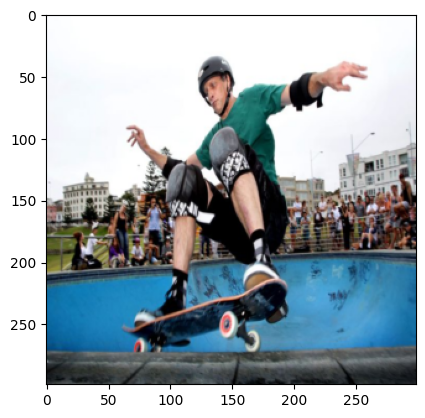

a man riding a skateboard on a ramp .
a man in a blue shirt is doing a trick
a man riding a skateboard on a ramp .
a man on a skateboard doing a trick
a man on a skateboard doing a trick
a man riding a skateboard on a ramp .
a man in a blue shirt is doing a trick
a man riding a skateboard down a ramp .
a man on a skateboard doing a trick .
a man riding a skateboard on a ramp .


In [41]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
%matplotlib inline

def imresize(img, size):
    if isinstance(img, np.ndarray):
        img = Image.fromarray((img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8))
    img = img.resize(size if isinstance(size, tuple) else (size, size), Image.BILINEAR)
    return np.array(img)

!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [45]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2025-10-30 09:22:22--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 52.14.223.199, 3.23.184.98
Connecting to ccanimalclinic.com (ccanimalclinic.com)|52.14.223.199|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-10-30 09:22:22 ERROR 404: Not Found.



UnidentifiedImageError: cannot identify image file 'data/img.jpg'

### 5. Demo (2.5 балла)
##### **Найдите как минимум 10 изображений для теста.**

* Серьёзно, это часть задания — подготовьте хотя бы 10 картинок для генерации подписей.

* Сначала проверьте работу модели на простых изображениях, прежде чем переходить к более сложным.

* В вашем наборе должны быть примеры как удачных, так и неудачных подписей — проявите креативность :)

* Используйте фотографии, а не анимацию, 3D или рисунки — иначе придётся переобучать CNN на аниме.

* Обратите внимание на соотношение сторон изображений.

In [ ]:
# apply your network on images you've found
#
#

Изображение 1/14: Собака
  1. (T=1.0): an air dark orange hangs and one another dog .
  2. (T=3.0): a dog laying on top of a bed with a dog .
  3. (T=5.0): a dog with a dog on a leash in the background .
Изображение 2/14: Кот
  1. (T=1.0): three toilets are placed on top of a glass bed .
  2. (T=3.0): a cat is sitting on a chair in front of a laptop .
  3. (T=5.0): a cat is sitting on a chair .
Изображение 3/14: Собака и кот вместе
  1. (T=1.0): a large blue and brown bow brown dog with sauerkraut
  2. (T=3.0): a dog that is sitting on a couch .
  3. (T=5.0): a dog that is sitting on a chair .
Изображение 4/14: Портрет женщины
  1. (T=1.0): a guy with a white shirt wearing a shirt .
  2. (T=3.0): a man in a white shirt and tie holding a wii controller .
  3. (T=5.0): a young girl is holding a remote control in his mouth .
Изображение 5/14: Портрет мужчины
  1. (T=1.0): a baseball player catches a picture in his plate .
  2. (T=3.0): a young boy wearing a tie and a tie .
  3. (T=5.0): a

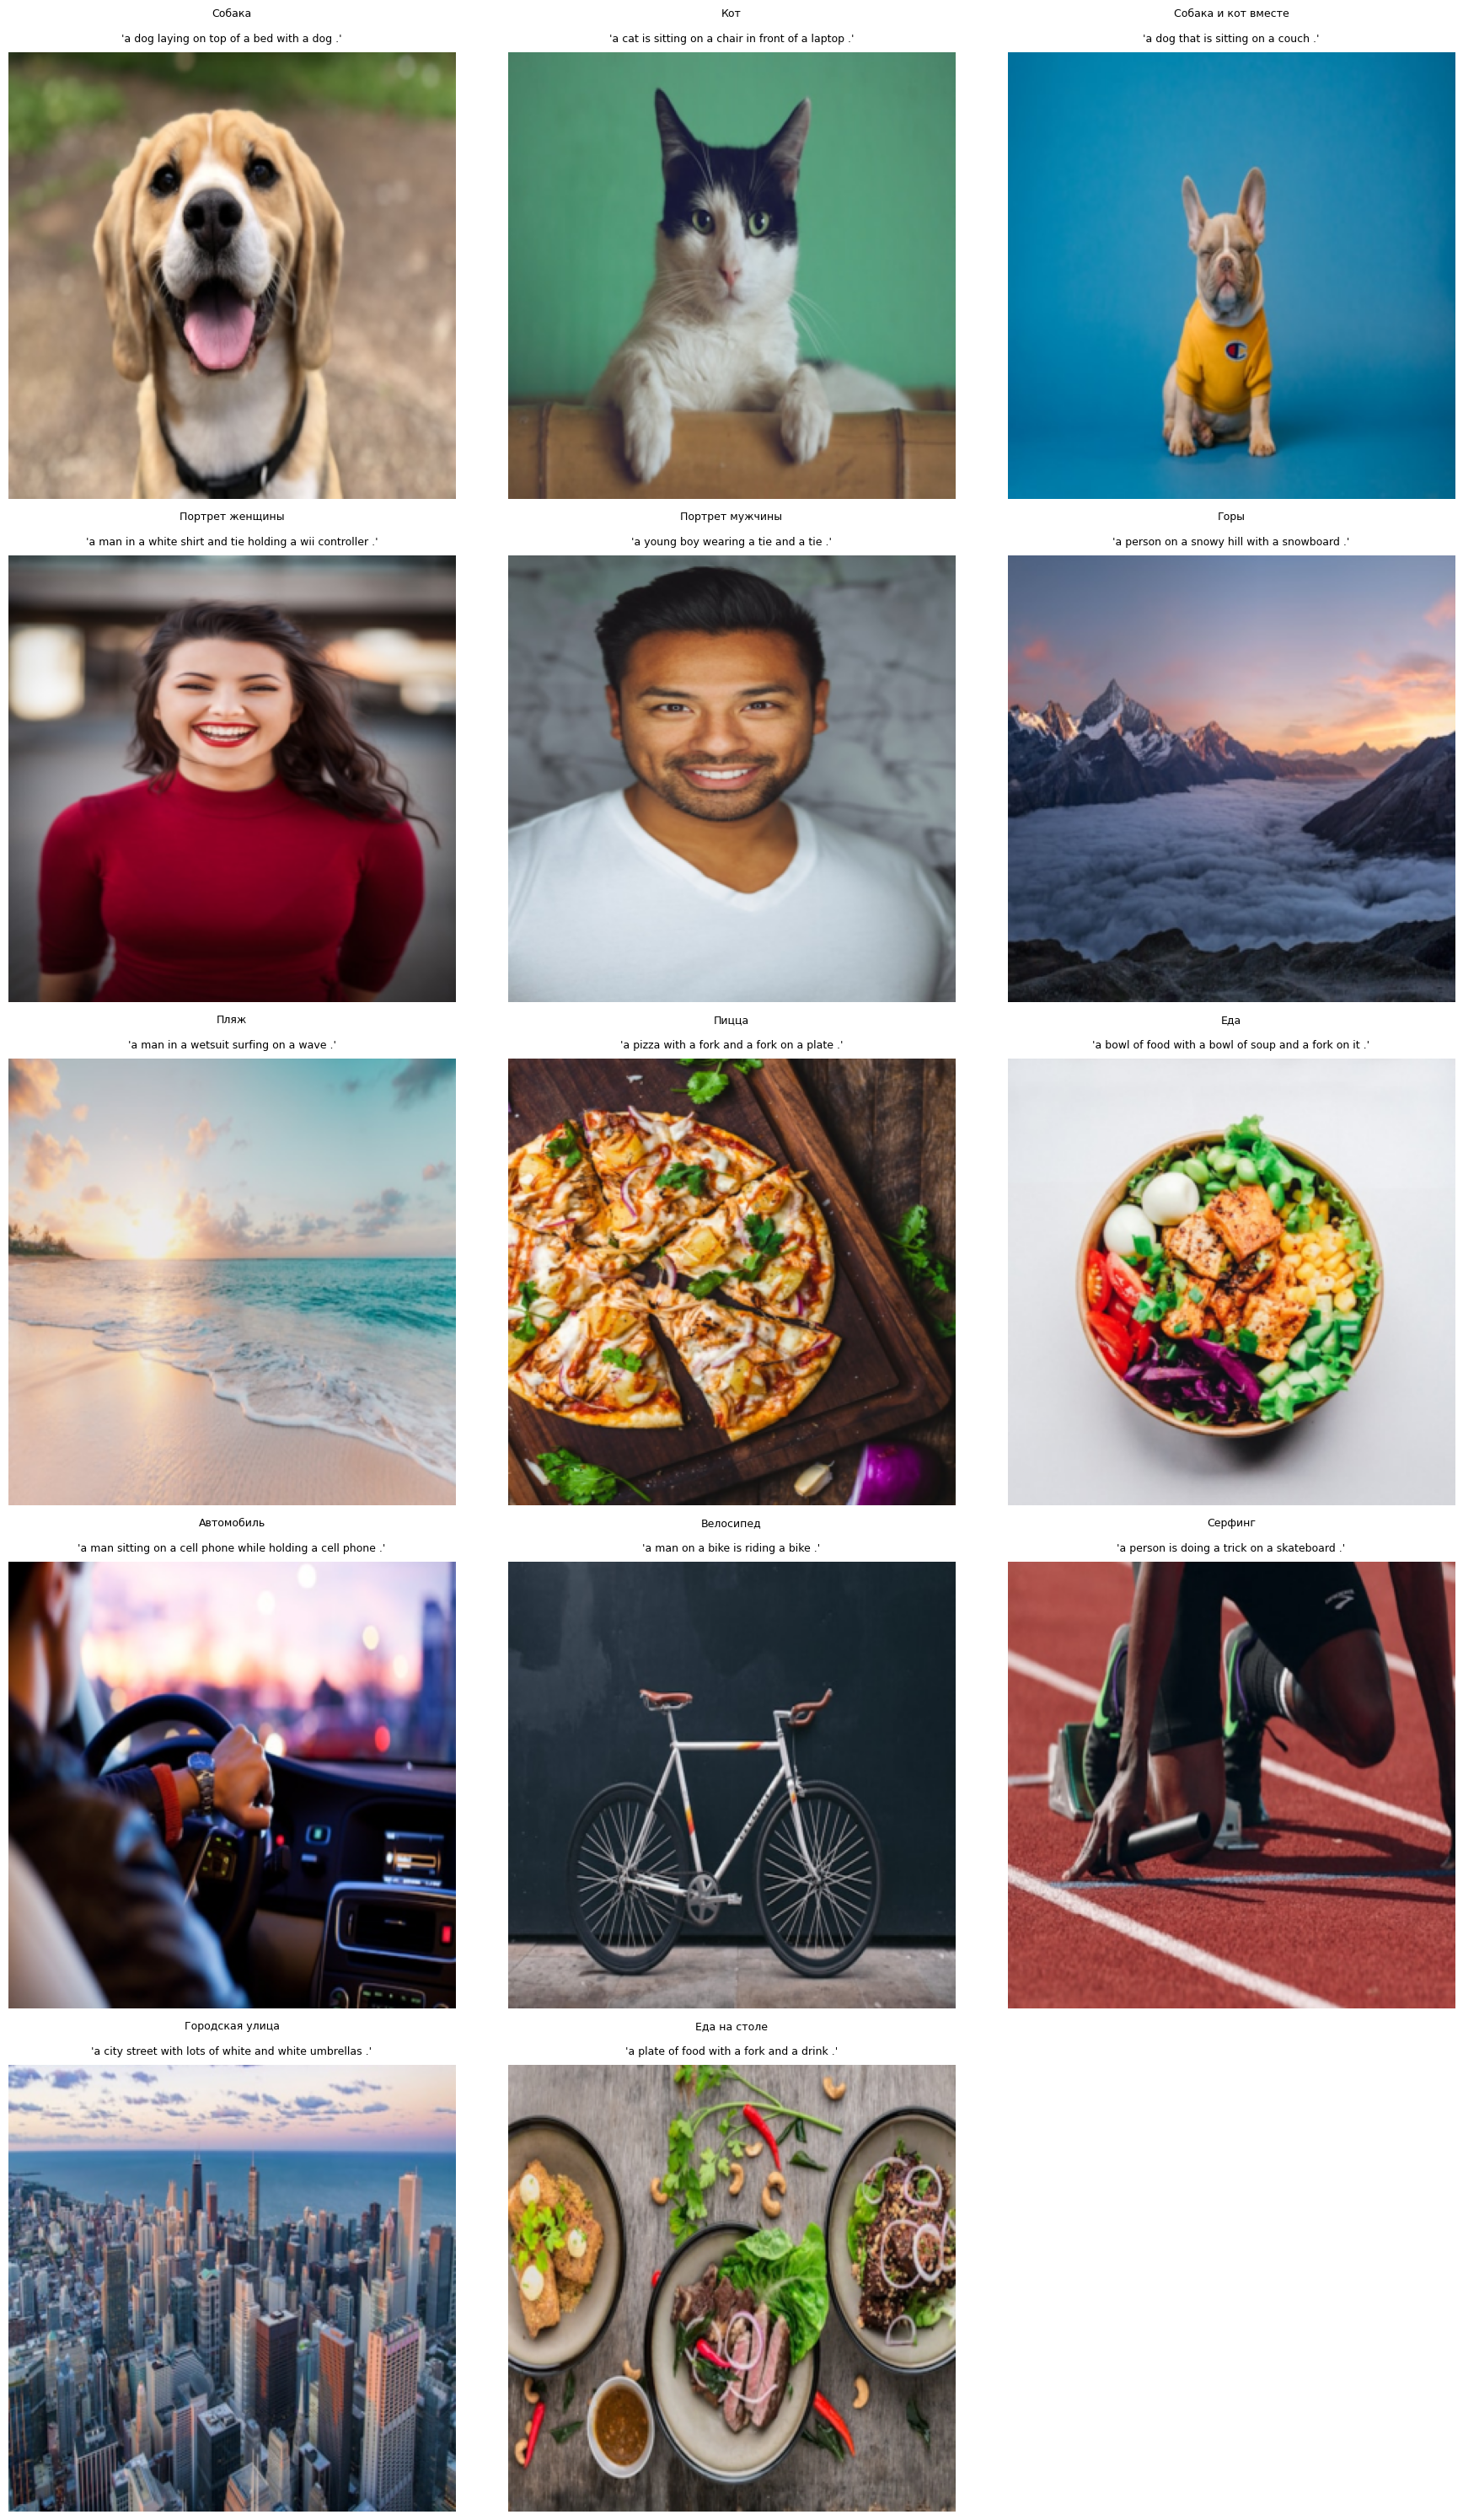

Успешно ПРОЧИТАНО: 14/14 изображений
СЛОМАННЫХ: 0/14 изображений

УСПЕШНЫЕ ПОДПИСИ:
 1. Собака                         → a dog laying on top of a bed with a dog .
 2. Кот                            → a cat is sitting on a chair in front of a laptop .
 3. Собака и кот вместе            → a dog that is sitting on a couch .
 4. Портрет женщины                → a man in a white shirt and tie holding a wii controller .
 5. Портрет мужчины                → a young boy wearing a tie and a tie .
 6. Горы                           → a person on a snowy hill with a snowboard .
 7. Пляж                           → a man in a wetsuit surfing on a wave .
 8. Пицца                          → a pizza with a fork and a fork on a plate .
 9. Еда                            → a bowl of food with a bowl of soup and a fork on it .
10. Автомобиль                     → a man sitting on a cell phone while holding a cell phone .
11. Велосипед                      → a man on a bike is riding a bike .
12. Серфин

In [47]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import requests
from io import BytesIO
%matplotlib inline

def load_image(source, size=(299, 299)):
    try:
        if isinstance(source, str):
            if source.startswith('http'):
                response = requests.get(source, timeout=10)
                img = Image.open(BytesIO(response.content))
            else:
                img = Image.open(source)
        elif isinstance(source, Image.Image):
            img = source
        elif isinstance(source, np.ndarray):
            return source
        else:
            raise ValueError("Unsupported image source type")

        if img.mode != 'RGB':
            img = img.convert('RGB')

        img = img.resize(size, Image.BILINEAR)
        img = np.array(img).astype('float32') / 255.

        return img
    except Exception as e:
        print(f"нЕ ЗАГРУЗИЛОСЬ {e}")
        return None

test_images = [
    ("https://images.unsplash.com/photo-1543466835-00a7907e9de1?w=500", "Собака"),
    ("https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=500", "Кот"),
    ("https://images.unsplash.com/photo-1583511655857-d19b40a7a54e?w=500", "Собака и кот вместе"),
    ("https://images.unsplash.com/photo-1494790108377-be9c29b29330?w=500", "Портрет женщины"),
    ("https://images.unsplash.com/photo-1507003211169-0a1dd7228f2d?w=500", "Портрет мужчины"),
    ("https://images.unsplash.com/photo-1506905925346-21bda4d32df4?w=500", "Горы"),
    ("https://images.unsplash.com/photo-1507525428034-b723cf961d3e?w=500", "Пляж"),
    ("https://images.unsplash.com/photo-1565299624946-b28f40a0ae38?w=500", "Пицца"),
    ("https://images.unsplash.com/photo-1546069901-ba9599a7e63c?w=500", "Еда"),
    ("https://images.unsplash.com/photo-1449965408869-eaa3f722e40d?w=500", "Автомобиль"),
    ("https://images.unsplash.com/photo-1485965120184-e220f721d03e?w=500", "Велосипед"),
    ("https://images.unsplash.com/photo-1461896836934-ffe607ba8211?w=500", "Серфинг"),
    ("https://images.unsplash.com/photo-1477959858617-67f85cf4f1df?w=500", "Городская улица"),
    ("https://images.unsplash.com/photo-1504674900247-0877df9cc836?w=500", "Еда на столе"),
]

# СЕТКА
n_images = len(test_images)
cols = 3
rows = (n_images + cols - 1) // cols

fig = plt.figure(figsize=(18, 6*rows))

results = []

for idx, (image_url, description) in enumerate(test_images, 1):
    print(f"Изображение {idx}/{n_images}: {description}")
    img = load_image(image_url)

    if img is None:
        print(f"НЕ ЗАГРУЗИЛОСЬ!")
        results.append((description, "ОШИБКА ЗАГРУЗКИ", None))
        continue

    captions = []
    for temp_idx, temperature in enumerate([1.0, 3.0, 5.0], 1):
        try:
            caption = generate_caption(img, t=temperature, sample=True)
            caption_text = ' '.join(caption[1:-1])
            captions.append(caption_text)
            print(f"  {temp_idx}. (T={temperature:.1f}): {caption_text}")
        except Exception as e:
            error_msg = str(e)[:100]
            print(f"  {temp_idx}. (T={temperature:.1f}): Ошибка: {error_msg}")
            captions.append("ERROR")

    # Выбираем лучшую подпись (средняя температура)
    best_caption = captions[1] if len(captions) > 1 and captions[1] != "ERROR" else captions[0] if captions else "NO CAPTION"

    # Отображаем в сетке
    ax = plt.subplot(rows, cols, idx)
    ax.imshow(img)
    ax.axis('off')
    title = f"{description}\n\n'{best_caption}'"
    ax.set_title(title, fontsize=9, wrap=True, pad=10)

    results.append((description, best_caption, img))

plt.tight_layout()
plt.savefig('caption_results.png', dpi=150, bbox_inches='tight')
plt.show()


successful = [r for r in results if r[1] not in ["ERROR", "ОШИБКА ЗАГРУЗКИ", "NO CAPTION"]]
failed = [r for r in results if r[1] in ["ERROR", "ОШИБКА ЗАГРУЗКИ", "NO CAPTION"]]

print(f"Успешно ПРОЧИТАНО: {len(successful)}/{len(results)} изображений")
print(f"СЛОМАННЫХ: {len(failed)}/{len(results)} изображений\n")

if successful:
    print("УСПЕШНЫЕ ПОДПИСИ:")
    for i, (desc, caption, _) in enumerate(successful, 1):
        print(f"{i:2d}. {desc:30s} → {caption}")

if failed:
    print("\n\nНЕУДАЧНЫЕ ПОПЫТКИ:")
    for i, (desc, error, _) in enumerate(failed, 1):
        print(f"{i:2d}. {desc:30s} → {error}")

print("\nРаспределение по категориям:")
categories = {
    'Животные': sum(1 for d, c, _ in successful if any(w in d.lower() for w in ['собака', 'кот'])),
    'Люди': sum(1 for d, c, _ in successful if 'портрет' in d.lower()),
    'Природа': sum(1 for d, c, _ in successful if any(w in d.lower() for w in ['горы', 'пляж'])),
    'Еда': sum(1 for d, c, _ in successful if 'еда' in d.lower() or 'пицца' in d.lower()),
    'Транспорт': sum(1 for d, c, _ in successful if any(w in d.lower() for w in ['автомобиль', 'велосипед'])),
}

for category, count in categories.items():
    if count > 0:
        print(f"  • {category}: {count} изображений")
